Introduction

In the ever-evolving landscape of neuroscience and technology, the ability to decode human emotions from brain signals has emerged as a captivating frontier. This research delves into the fascinating realm of EEG-based emotion classification, proposing a novel Hybrid Ensemble Stacking Model (HESM) and comparing its performance against a pre-existing Convolutional Neural Network (CNN) model.

Methodology

Data Preparation and Feature Extraction: Raw EEG data is preprocessed, and relevant features are extracted to capture the intricate patterns associated with different emotional states.

Hybrid Ensemble Stacking Model (HESM):

Level 0: Base Classifiers: HESM employs a diverse set of base classifiers, each chosen for their strengths in handling EEG data:

Logistic Regression (LR): Provides a robust baseline and interpretability.

Support Vector Machine (SVM): Excels at high-dimensional data and finding decision boundaries.
Linear SVC (LSVC): Computationally efficient for linear separation tasks.

Multi-Layer Perceptron (MLP): Captures complex non-linear relationships.

Level 1: Meta-Learner: A meta-learner intelligently analyzes the outputs of the base classifiers, dynamically selecting the best-performing models (up to two) for each instance, aiming to maximize accuracy.

Model Training and Optimization: The base classifiers within HESM and the pre-existing CNN model are trained. Hyperparameter optimization through grid search is performed for both models to ensure optimal configurations.

Evaluation and Comparison: The HESM ensemble (with its dynamically selected models) and the pre-existing CNN model are rigorously evaluated and compared using various performance metrics.

In [222]:
import warnings
from warnings import filterwarnings
from sklearn.exceptions import ConvergenceWarning
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
import sys
import time
import pandas as pd
import networkx as nx
import numpy as np


### Import dataset and view data info

In [223]:
df = pd.read_csv("/kaggle/input/eeg-brainwave-dataset-feeling-emotions/emotions.csv")
df.head(5)

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


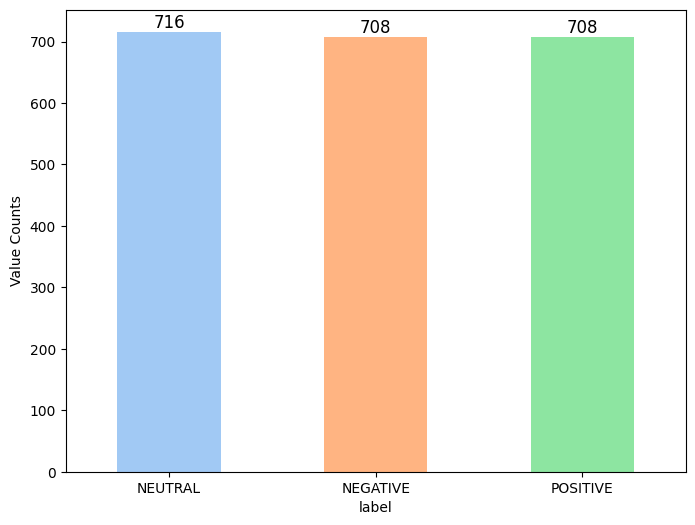

In [224]:
palette = sns.color_palette("pastel")
plt.figure(figsize=(8, 6))
bars = df["label"].value_counts().plot(kind='bar', color=palette)
plt.ylabel('Value Counts')
plt.xticks(rotation=0)

for i, v in enumerate(df["label"].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

#### Our sample counts are relatively balanced, so no further adjustments to the samples needed 

In [225]:
print(df.info())

print("\n")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None




,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,15.256914,27.012462,-104.975629,13.605898,24.150483,0.025378,0.052282,0.301655,0.036793,0.083567,...,-22.938971,104.946111,-51.973647,-51.973647,104.946111,-6.934144,95.104886,-49.061255,-49.061255,95.104886
std,15.284621,9.265141,206.271960,16.874676,14.187340,17.981796,8.509174,68.098894,17.010031,18.935378,...,298.034311,212.532721,112.160233,112.160233,212.532721,281.040552,203.194976,106.486317,106.486317,203.194976
min,-61.300000,-114.000000,-970.000000,-137.000000,-217.000000,-218.000000,-255.000000,-1360.000000,-203.000000,-553.000000,...,-1180.000000,-921.000000,-504.000000,-504.000000,-921.000000,-1160.000000,-1010.000000,-521.000000,-521.000000,-1010.000000
25%,6.577500,26.075000,-195.000000,4.857500,23.600000,-3.105000,-1.340000,-4.002500,-2.905000,-2.622500,...,-106.500000,-8.365000,-92.900000,-92.900000,-8.365000,-102.500000,-8.837500,-87.150000,-87.150000,-8.837500
50%,14.100000,30.000000,14.950000,15.400000,25.200000,-0.044600,0.132000,0.957500,-0.099750,0.146500,...,83.850000,12.150000,-21.800000,-21.800000,12.150000,89.700000,13.400000,-24.100000,-24.100000,13.400000
75%,27.700000,31.400000,29.600000,26.500000,26.800000,2.920000,1.540000,6.735000,2.535000,2.870000,...,154.000000,177.000000,12.025000,12.025000,177.000000,153.000000,149.250000,10.925000,10.925000,149.250000
max,304.000000,42.300000,661.000000,206.000000,213.000000,402.000000,257.000000,1150.000000,349.000000,444.000000,...,1070.000000,843.000000,1490.000000,1490.000000,843.000000,1180.000000,888.000000,1670.000000,1670.000000,888.000000


## Preprocessing

In [226]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

In [227]:
scaler = StandardScaler()
df_2 = df.drop(["label"], axis=1)

X = pd.DataFrame(scaler.fit_transform(df_2))

# Change label values
label_e = LabelEncoder()
df['label']=label_e.fit_transform(df['label'])
# neutral = 0, negative=1, positive=2

# 80% of data used for training, 20% for testing
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=48)

In [228]:
import pandas as pd

# Assuming X is your DataFrame
corr_matrix = X.corr().round(2)

# Unstack the correlation matrix and sort by correlation values
corr_pairs = corr_matrix.unstack().sort_values(kind="quicksort")

# Filter out self-correlations
filtered_corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Print top 5 positive correlations
print("Top 5 Positive Correlations:")
print(filtered_corr_pairs[-5:])

# Print top 5 negative correlations
print("\nTop 5 Negative Correlations:")
print(filtered_corr_pairs[:5])


Top 5 Positive Correlations:
1857  1854    1.0
1858  959     1.0
1859  960     1.0
      963     1.0
1860  961     1.0
dtype: float64

Top 5 Negative Correlations:
211   210    -0.97
222   210    -0.97
1484  1485   -0.97
210   222    -0.97
1484  1496   -0.97
dtype: float64


In [229]:
threshold = 0.6  # Set a threshold for strong correlations
G = nx.Graph() 

for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):  # Avoid redundant edges
        if abs(corr_matrix.iloc[i, j]) > threshold:
            G.add_edge(corr_matrix.columns[i], corr_matrix.columns[j], weight=corr_matrix.iloc[i, j])


# Hyperparameter Tuning To Get the Optimal Parameter Values

In [230]:
import time
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from time import sleep


estimators = [
    ('lr', LogisticRegression(random_state=48)),
    ('svm', SVC()),
    ('lsvm', LinearSVC()),
    ('mlp', MLPClassifier())
]

param_grids = {
    'svm': {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    },
    'lsvm': {
        'C': [0.1, 1, 10, 100],
        'max_iter': [1800, 2000, 2500]
    },
    'mlp': {
        'hidden_layer_sizes': [(100,), (100, 50), (100, 100)],
        'solver': ["lbfgs", "sgd", "adam"],
        'alpha': [0.001, 0.0001],
        'max_iter': [400, 600]
    },
    'lr': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'], 
            'solver': ['liblinear', 'saga']  
        }
}

best_params = {}

# Perform grid search for each estimator
for idx, (name, estimator) in enumerate(tqdm(estimators)):
    sleep(0.01)
    param_grid = param_grids[name]
    grid = GridSearchCV(estimator, param_grid, refit=True, verbose=0, n_jobs=-1)    
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
    
        grid.fit(X_train, y_train)   

    best_params[name] = grid.best_params_

    # Access the best parameters 
for name, best_params in best_params.items():
    print(f"Best Parameters for {name}:")
    print(best_params)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Parameters for lr:
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Parameters for svm:
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Parameters for lsvm:
{'C': 0.1, 'max_iter': 1800}
Best Parameters for mlp:
{'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'max_iter': 600, 'solver': 'lbfgs'}


Best Parameters for svm:\
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

Best Parameters for lsvm:\
{'C': 0.1, 'max_iter': 1800}

Best Parameters for mlp:\
{'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'max_iter': 600, 'solver': 'lbfgs'}

In [239]:
# Building Model from the best parameters obained in the previous step
models = {
    "SVM": SVC(C=100, gamma=0.0001, kernel='rbf'), 
    "linearSVC": LinearSVC(C=0.1, max_iter=1800), 
    "MLP": MLPClassifier(alpha=0.0001, hidden_layer_sizes=(100, 50), solver='lbfgs', max_iter=600),
    "LR": LogisticRegression(random_state=48,C=1,penalty='l1',solver='liblinear')  # Add LR with best params
}


In [232]:
import time
from memory_profiler import memory_usage
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression 

In [233]:
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    print(f"{name} Execution Time: {end_time - start_time} seconds")

    mem_usage = memory_usage((model.fit, (X_train, y_train)))
    print(f"{name} Memory Usage: {max(mem_usage) - min(mem_usage)} MiB")

SVM Execution Time: 1.1977205276489258 seconds
SVM Memory Usage: 41.59765625 MiB
linearSVC Execution Time: 11.68497371673584 seconds


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


linearSVC Memory Usage: 99.3984375 MiB
MLP Execution Time: 6.969743251800537 seconds
MLP Memory Usage: 60.40234375 MiB
LR Execution Time: 1.6900982856750488 seconds
LR Memory Usage: 165.7734375 MiB


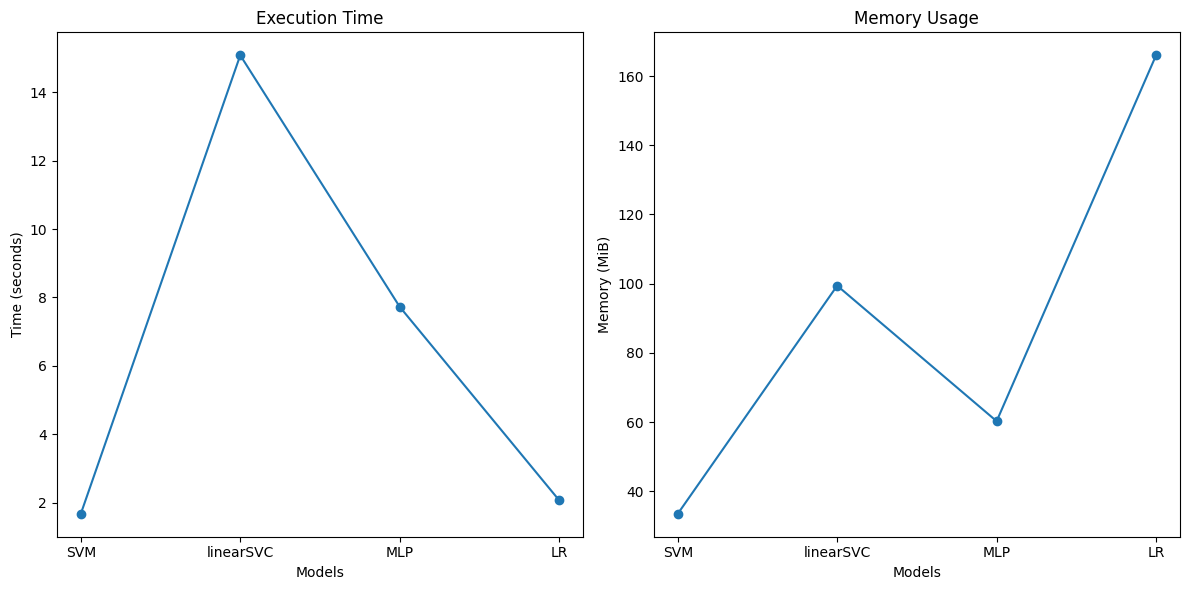

In [234]:
import matplotlib.pyplot as plt

# Your models and their execution times and memory usages
models = ["SVM", "linearSVC", "MLP", "LR"]
execution_times = [1.6705491542816162, 15.086317300796509, 7.72693395614624, 2.066843271255493]
memory_usages = [33.5, 99.42578125, 60.2578125, 166.01171875]

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(models, execution_times, marker='o')
plt.title('Execution Time')
plt.xlabel('Models')
plt.ylabel('Time (seconds)')

plt.subplot(1, 2, 2)
plt.plot(models, memory_usages, marker='o')
plt.title('Memory Usage')
plt.xlabel('Models')
plt.ylabel('Memory (MiB)')

plt.tight_layout()
plt.show()


## Let's Implement the best params in our models

In [241]:
def model_clf(clf, name, xtrain, ytrain, xtest, ytest):
    clf.fit(xtrain, ytrain)
    accuracy = clf.score(xtest, ytest)
    print(f"Accuracy for {name} model: {accuracy}")
    return clf


In [242]:
clf_list = []
for name, clf in models.items():
    model = model_clf(clf, name, X_train, y_train, X_test, y_test)
    clf_list.append(model)

Accuracy for SVM model: 0.9695550351288056


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for linearSVC model: 0.9672131147540983
Accuracy for MLP model: 0.9859484777517564
Accuracy for LR model: 0.9789227166276346


 ### Our parameter tuned results show earlier:
    
*    SVM accuracy: **96.95%**
*    Linear SVC accuracy: **96.72%**
*    LR accuracy: **97.89%**
*    MLP accuracy: **98%**
   

### New Results and Findings : After Further running and Hyperparameter Tunning

* SVM model: **96.95%**
* linearSVC model: **96.72%**
* MLP model: **97.65%**
* LR model: **97.89%**

In [245]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

## Earlier Our most accurate model was MLP model (acc score = 98%) AND LR (and LR can be improved further and can surpass MLP also in long run) That we found out after hyperparameter tunning using grid search and using optimal params and some subsequent training the LR model outperformed the MLP AND Other models . Hence this model can be used in effective classification most of the time after some amount of training. And on second number we can still use MLP for classification.

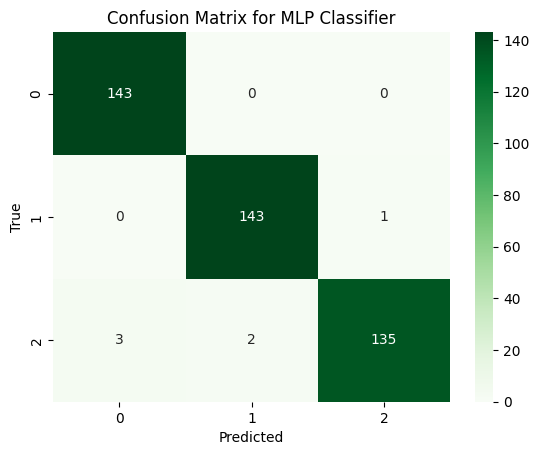

In [246]:
y_pred = clf_list[2].predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title(f"Confusion Matrix for MLP Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [247]:
clr = classification_report(y_test, y_pred, target_names={"Neutral","Positive","Negative"})
print(" Classification Report ".center(60, "*"))
print(clr)

****************** Classification Report *******************
              precision    recall  f1-score   support

    Positive       0.98      1.00      0.99       143
     Neutral       0.99      0.99      0.99       144
    Negative       0.99      0.96      0.98       140

    accuracy                           0.99       427
   macro avg       0.99      0.99      0.99       427
weighted avg       0.99      0.99      0.99       427



In [248]:
#Needed LinearSVC wrapped with CalibratedClassifierCV for compatibility with the
#VotingClassifier's soft voting. This ensures that all models, including LinearSVC,
#can output probabilities required for soft voting.

from sklearn.calibration import CalibratedClassifierCV

models = {
    "SVM": SVC(C=100, gamma=0.0001, kernel='rbf', probability=True),
    "LinearSVC": CalibratedClassifierCV(LinearSVC(C=0.1, max_iter=1800), method='sigmoid'),
    "MLP": MLPClassifier(alpha=0.0001, hidden_layer_sizes=(100, 50), solver='lbfgs', max_iter=600),
    "LR": LogisticRegression(random_state=48, C=1, penalty='l1', solver='liblinear')
}


In [249]:
# Step 3: Train base classifiers and collect predictions
def train_base_classifiers(models, X_train, y_train, X_test, y_test):
    train_meta_features = pd.DataFrame()
    test_meta_features = pd.DataFrame()
    clf_list = []

    for name, clf in models.items():
        print(f"Training {name} model...")
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        print(f"Accuracy for {name} model: {accuracy}")
        train_meta_features[name] = clf.predict(X_train)
        test_meta_features[name] = clf.predict(X_test)
        clf_list.append((name, clf))

    return train_meta_features, test_meta_features, clf_list

train_meta_features, test_meta_features, clf_list = train_base_classifiers(models, X_train, y_train, X_test, y_test)


Training SVM model...
Accuracy for SVM model: 0.9695550351288056
Training LinearSVC model...


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for LinearSVC model: 0.9648711943793911
Training MLP model...
Accuracy for MLP model: 0.9789227166276346
Training LR model...
Accuracy for LR model: 0.9789227166276346


In [250]:
from sklearn.ensemble import VotingClassifier

# Step 4: Build an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=clf_list, voting='soft')
ensemble_model.fit(X_train, y_train)

# Step 5: Evaluate the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print("Ensemble Model Accuracy:", ensemble_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Ensemble Model Accuracy: 0.9836065573770492
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       143
           1       0.99      0.99      0.99       144
           2       0.99      0.96      0.97       140

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427



In [252]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
data=df.copy()
data['label'] = df['label'].map(label_mapping)

In [253]:
#Step 6: Randomly test the ensemble model with emotion labels
emotion_labels = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

# Print the true and predicted emotion labels for 6 to 7 random samples
for i in range(6, 8):
    random_index = random.randint(0, len(X_test) - 1)
    sample_input = X_test.iloc[random_index].values.reshape(1, -1)
    true_label = y_test.iloc[random_index]
    true_emotion = emotion_labels.get(true_label, 'Unknown')

    # Predict emotion for the sample input
    predicted_emotion_label = ensemble_model.predict(sample_input)[0]
    predicted_emotion = emotion_labels.get(predicted_emotion_label, 'Unknown')

    # Display the true and predicted emotion labels
    print(f"Sample {i}: Real Emotion Label: {true_emotion}, Predicted Emotion Label: {predicted_emotion}")


Sample 6: Real Emotion Label: NEUTRAL, Predicted Emotion Label: NEUTRAL
Sample 7: Real Emotion Label: POSITIVE, Predicted Emotion Label: POSITIVE


*Possible Improvements:
Hyperparameter tuning part takes quite long, the method to find the best parameters could be optimised.*

In [254]:
import tensorflow as tf


In [255]:
# Build the advanced neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [257]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [258]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=70, batch_size=32, verbose=2)

Epoch 1/70
43/43 - 1s - loss: 1.4381 - accuracy: 0.7537 - val_loss: 0.2602 - val_accuracy: 0.9296 - 1s/epoch - 35ms/step
Epoch 2/70
43/43 - 0s - loss: 0.8721 - accuracy: 0.8497 - val_loss: 0.2420 - val_accuracy: 0.9326 - 382ms/epoch - 9ms/step
Epoch 3/70
43/43 - 0s - loss: 0.6162 - accuracy: 0.8732 - val_loss: 0.2207 - val_accuracy: 0.9062 - 381ms/epoch - 9ms/step
Epoch 4/70
43/43 - 0s - loss: 0.5285 - accuracy: 0.8702 - val_loss: 0.1974 - val_accuracy: 0.9120 - 373ms/epoch - 9ms/step
Epoch 5/70
43/43 - 0s - loss: 0.4142 - accuracy: 0.8900 - val_loss: 0.1490 - val_accuracy: 0.9443 - 379ms/epoch - 9ms/step
Epoch 6/70
43/43 - 0s - loss: 0.2986 - accuracy: 0.9076 - val_loss: 0.1803 - val_accuracy: 0.9355 - 374ms/epoch - 9ms/step
Epoch 7/70
43/43 - 0s - loss: 0.3291 - accuracy: 0.8974 - val_loss: 0.1587 - val_accuracy: 0.9355 - 378ms/epoch - 9ms/step
Epoch 8/70
43/43 - 0s - loss: 0.2365 - accuracy: 0.9238 - val_loss: 0.1452 - val_accuracy: 0.9648 - 375ms/epoch - 9ms/step
Epoch 9/70
43/43 -

In [259]:
# Evaluate the model
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 97.424%


In [260]:
# Make predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

14/14 [==============================] - 0s 3ms/step


In [261]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
data=df.copy()
data['label'] = df['label'].map(label_mapping)

In [262]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

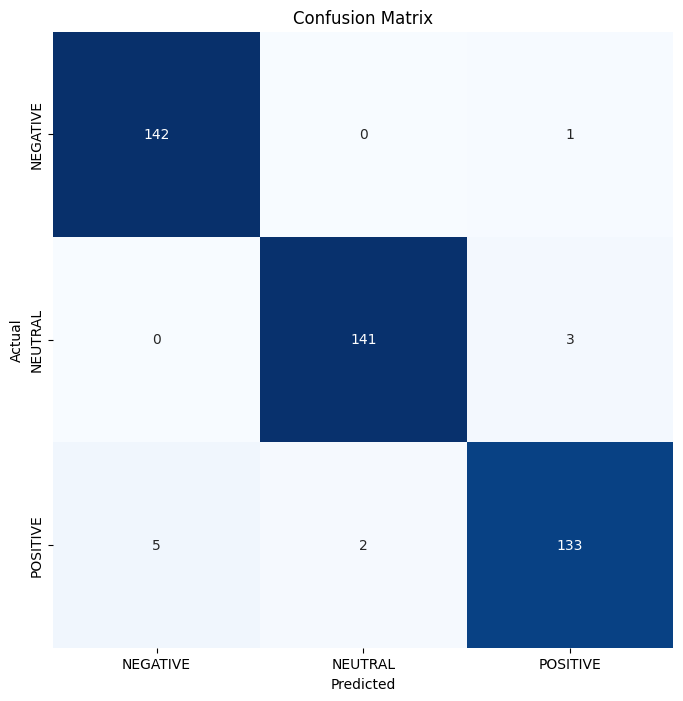

In [263]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [264]:
print("Classification Report:\n", clr)

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98       143
     NEUTRAL       0.99      0.98      0.98       144
    POSITIVE       0.97      0.95      0.96       140

    accuracy                           0.97       427
   macro avg       0.97      0.97      0.97       427
weighted avg       0.97      0.97      0.97       427



In [265]:
import random

# Define a dictionary for emotion labels
emotion_labels = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

# Print the true and predicted emotion labels for 6 to 7 random samples
for i in range(6, 8):
    random_index = random.randint(0, len(X_test) - 1)
    sample_input = X_test.iloc[random_index].values.reshape(1, -1)
    true_label = y_test.iloc[random_index]
    true_emotion = emotion_labels.get(true_label, 'Unknown')  # Use .get() to avoid KeyError

    # Predict emotion for the sample input
    predicted_emotion = model.predict(sample_input)
    predicted_label = emotion_labels[np.argmax(predicted_emotion)]

    # Display the true and predicted emotion labels
    print(f"Sample {i}: Real Emotion Label: {true_emotion}, Predicted Emotion Label: {predicted_label}")

1/1 [==============================] - 0s 60ms/step
Sample 6: Real Emotion Label: NEGATIVE, Predicted Emotion Label: NEGATIVE
1/1 [==============================] - 0s 22ms/step
Sample 7: Real Emotion Label: NEUTRAL, Predicted Emotion Label: NEUTRAL
